In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm

from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

In [2]:
from sklearn.datasets import fetch_openml

def make_n_classes(n, y):
    dic = dict(zip(y.value_counts().head(n - 1).index, range(n - 1)))
    return np.array(list(map(lambda x: dic.get(x, n - 1), y)))

def read_dataset():
    X, y_original = fetch_openml(
        data_id=4541, parser="auto", return_X_y=True, as_frame=True
    )
    y = make_n_classes(3, y_original)
    X = X.drop(columns=["encounter_id", "patient_nbr"])
    return X, y

___

To illustrate the discussion of threshold optimization in the multiclass case, we will use [`sklearn.datasets.fetch_openml`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html) with `data_id=4541`. This dataset has three classes, but, as we will see later, the strategy is generic for any number of classes. The choice of three was just for better visualization.

In [3]:
X, y = read_dataset()

X_train_model, X_test, y_train_model, y_test = train_test_split(X, y, random_state=0, stratify=y)
X_train_model, X_train_threshold, y_train_model, y_train_threshold = \
train_test_split(X_train_model, y_train_model, test_size=0.2, random_state=0, stratify=y_train_model)

In a multiclass classification problem (with `n` classes), the "probabilistic" output of a typical scikit-learn classifier will be a vector with a `.shape` of `(n_samples, n)`. For each example, this vector of `n` components gives us the "probability" of each example belonging to the class associated with that index. That is, the first component is the probability of the examples belonging to the first class, the second component is the probabilities of the second class, and so on.

In [4]:
model = LGBMClassifier(max_depth=4, random_state=42).fit(X_train_model, y_train_model)

probs = model.predict_proba(X_train_threshold)
preds = model.predict(X_train_threshold)

print(f"Number of samples in X_train_threshold: {X_train_threshold.shape[0]}.",
      f"Number of classes: {len(np.unique(y))}.",
      f"\nprobs.shape: {probs.shape}.")

Number of samples in X_train_threshold: 15265. Number of classes: 3. 
probs.shape: (15265, 3).


Because it represents a probability, this vector is such that its lines always add up to 1; that is, the probability of a sample being in one of the classes is 1.

In [5]:
(np.isclose(probs.sum(axis=1), 1)).all()

True

The vector space of `n` dimensions such that its components add up to 1 is called the $\mathbb{R}^n$ simplex, or just n-simplex. In the case where the number of classes is 2, then the simplex becomes a line that goes from the point $(1, 0)$ to the point $(0, 1)$ and can be parameterized directly by the probability of one of the classes, for example as $\left\{ (1-p, p) : p \in [0, 1] \right\}$. This simplification is why the binary ranking metrics of famous machine learning libraries like scikit-learn ask to pass only the probability of the second class to the functions that calculate these metrics by doing something like `roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])`.

This simplification from 2-dimensional simplex to a line allows choosing thresholds in a simple way to transform the model's probabilistic output into hard predictions (that is, choosing only one of the classes).

In a [previous post on hyperparameter optimization for threshold-dependent metrics](https://vitaliset.github.io/threshold-dependent-opt/), we have already discussed a possible strategy to perform this transformation. In pseudocode:

```plaintext
1. Define a metric of interest that you want to optimize with the
threshold-setting process.
2. Select several different threshold values t in (0, 1) interval such that
your new .predict will be of the form "if .predict_proba > t, then predict 1;
otherwise, predict 0. In general, you can create a simple grid using
np.linspace.
3. Calculate your metric with each possible value of t from your grid of values
and choose the best threshold value (according to some criterion - for example,
the threshold that explicitly provided the best value for your metric of
interest).
```

This works well for the binary case, but it is not immediate to extend this idea to the case of three classes, much less to a generic case where we have `n` classes. For example, for three classes, the 3-simplex that used to be a line becomes a triangle, an object more complex to divide.

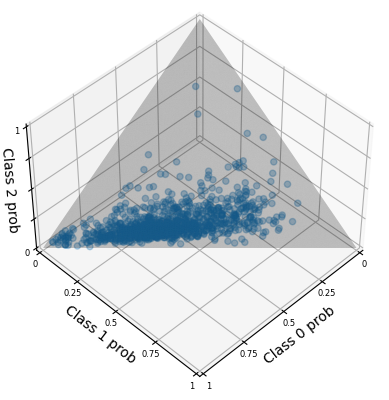

In [6]:
from utils import plot_simplex, clean_simplex_ax, plot_3d_regions_over_simplex

plot_sample = np.random.RandomState(42).choice(len(probs), 1000, replace=False)

ax = clean_simplex_ax(plot_simplex())
ax.scatter(xs=probs[plot_sample, 0], ys=probs[plot_sample, 1], zs=probs[plot_sample, 2], alpha=0.3)

plt.show()

It is not immediate to think about how to parameterize the division of this object into three regions, unlike the trivial division of the two-dimensional simplex where defining `t` was enough for one region to be predicted as a value and the other region as another.

The idea of this post is to tackle this problem in a generic enough way to be applicable in problems with any `n` number of classes.

___

## Understanding the usual prediction

In scikit-learn, the implementation of `.predict`, in general, follows the logic [implemented](https://github.com/scikit-learn/scikit-learn/blob/98cf537f5c538fdbc9d27b851cf03ce7611b8a48/sklearn/ensemble/_forest.py#L800-L837) for [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):

```python
def predict(self, X):
    ...
    proba = self.predict_proba(X)
    ...
    return self.classes_.take(np.argmax(proba, axis=1), axis=0)
```

This means that given a vector in simplex, the predicted value is that of the component such that it is larger. This `np.argmax` logic is equivalent to finding which vertex is closest to that point in the simplex.

We can verify this fact in our example using a [`sklearn.neighbors.NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) and verifying that the index of the nearest neighbors matches the value that our `.predict` previously returned.

**Proposition**. Let $\vec p \equiv (p_1,\ldots, p_k)$ be a probability vector. Let the $k$ simplex vertices be given by $\vec d_i$ , with components $(\vec d_i)_j = \delta_{ij}$. Then, for any $p \geq 1$, it holds that

$$\mathrm{arg}\max_j p_j = \mathrm{arg}\min_j \|\vec p - \vec d_j\|_p.$$

where $\|\cdot\|_p$ is the $p$-norm on Euclidean space.

*Proof*:

$$\|\vec p - \vec d_j\|_p^p=\sum_i (p_i-\delta_{ij})^p=\sum_{i\neq j}p_i^p+(1-p_j)^p.$$

Since $p\geq 1$ and $0\leq p_i\leq 1$ it holds that $p_i^p \leq p_i$, $(1-p_j)^p \leq 1-p_j$, whence

$$\begin{align*}
\|\vec p - \vec d_j\|_p^p &\leq \sum_{i\neq j}p_i +1 - p_j\\ &=\sum_ip_i+1-2p_j \quad \mbox{(adding and subtracting $p_j$)}\\ &=2(1-p_j).
\end{align*}$$

It holds from this and the fact that $x \mapsto x^p$ is increasing for non-negative $x$ that

$$\begin{align*}
\mathrm{arg}\min_j \|\vec p - \vec d_j\|_p &= \mathrm{arg}\min_j \|\vec p - \vec d_j\|_p^p\\ &=
\mathrm{arg}\min_j \;2(1-p_j)\\ &=
\mathrm{arg}\max_j p_j.\qquad \Box
\end{align*}$$

In [7]:
edges_of_simplex = np.identity(3)
edges_of_simplex

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [8]:
nn = NearestNeighbors(n_neighbors=1, p=2).fit(edges_of_simplex)
_, ind = nn.kneighbors(probs)

(ind[:, 0] == preds).all()

True

We see this fact visually that the Voronoi diagram of the corners breaks the simplex in the regions defined by [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

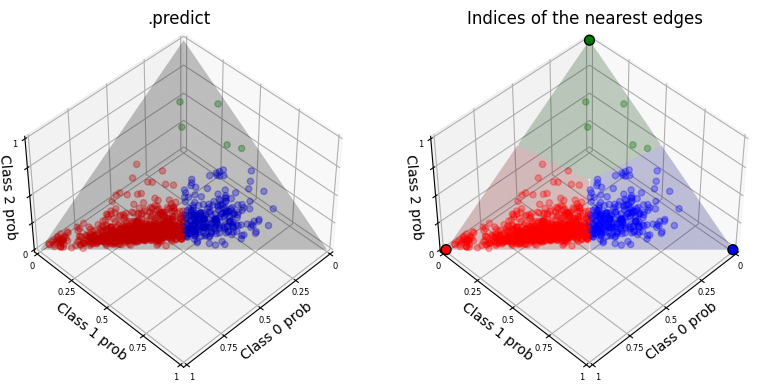

In [9]:
color_dic = dict(zip(range(3), ["r", "b", "g"]))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = (
    fig.add_subplot(1, 2, 1, projection="3d"),
    fig.add_subplot(1, 2, 2, projection="3d")
)


color_list_preds = [color_dic[x] for x in preds[plot_sample]]
ax[0].scatter(
    probs[plot_sample, 0],
    probs[plot_sample, 1],
    zs=probs[plot_sample, 2],
    c=color_list_preds, alpha=0.3
)
ax[0].set_title(".predict")
plot_simplex(ax[0])

color_list_nn = [color_dic[x] for x in ind[plot_sample, 0]]
ax[1].scatter(
    xs=probs[plot_sample, 0],
    ys=probs[plot_sample, 1],
    zs=probs[plot_sample, 2],
    c=color_list_nn, alpha=0.3
)
ax[1].scatter(
    xs=edges_of_simplex[:, 0],
    ys=edges_of_simplex[:, 1],
    zs=edges_of_simplex[:, 2],
    c=["r", "b", "g"], s=50, edgecolor="k", alpha=1
)
ax[1].set_title("Indices of the nearest edges")
plot_3d_regions_over_simplex(nn, ax[1])

for axis in ax:
    clean_simplex_ax(axis)

plt.show()

This does not only happen in the case of dimension three and it is possible to generalize our theorem to any number of dimensions. Here, let's see this happening computationally in the same way we tested it in the case of three classes.

In [10]:
for N_CLASSES in tqdm(range(2, 11)):
    X_n_classes, y_n_classes = make_classification(
        n_samples=1000, n_features=30, n_informative=22, n_classes=N_CLASSES, random_state=42
    )

    model_n_classes = LGBMClassifier(max_depth=4, random_state=42).fit(X_n_classes, y_n_classes)

    probs_n_classes = model_n_classes.predict_proba(X_n_classes)
    preds_n_classes = model_n_classes.predict(X_n_classes)

    edges_of_simplex_n_classes = np.identity(N_CLASSES)

    nn_n_classes = NearestNeighbors(n_neighbors=1, p=2).fit(edges_of_simplex_n_classes)

    _, ind_n_classes = nn_n_classes.kneighbors(probs_n_classes)
    assert (ind_n_classes[:, 0] == preds_n_classes).all()

100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


This perception allows us to extend this idea: what if we move what we call corners to other points in the simplex and build the Voronoi diagram with these new centroids?

___

## Defining new centroids of the Voronoi diagram

We can draw random points from our simplex as our new "corner" candidates. These new points define [influence diagrams (Voronoi)](https://en.wikipedia.org/wiki/Voronoi_diagram) different from the initial ones in which the centroids were those of the type `centroids_candidates = np.identity(3)`.

To draw points evenly in simplex, we need to implement a little trick in the `sample_uniform_random_vectors_over_simplex` function.

In [11]:
# https://stackoverflow.com/questions/65154622/sample-uniformly-at-random-from-a-simplex-in-python
def sample_uniform_random_vectors_over_simplex(n, d=3, random_state=None):
    """Generate uniformly random vectors over a d-simplex.

    Parameters
    ----------
    n : int
        The number of random vectors to generate.

    d : int, default=3
        The dimension of the simplex.

    random_state : int or None, default=None
        Controls the random number generator used to generate the random
        vectors. Pass an int for reproducible results across multiple function
        calls.

    Returns
    -------
    random_sample : array-like of shape (n, d)
        The n uniformly random vectors in the d-simplex.

    Notes
    -----
    This function uses an exponential distribution to generate random points
    within the simplex.

    References
    ----------
    .. [1] Onn, S., & Weissman, I. (2011). Generating uniform random vectors
    over a simplex with implications to the volume of a certain polytope and
    to multivariate extremes. Annals of Operations Research, 189(1), 331-342.

    Examples
    --------
    >>> random_vectors = uniform_random_vectors_over_simplex(5, d=3)
    """
    random_gen = np.random.RandomState(random_state)
    k = random_gen.exponential(scale=1.0, size=(d, n))
    random_sample = (k / k.sum(axis=0)).T
    return random_sample


In [12]:
centroids_candidates = sample_uniform_random_vectors_over_simplex(n=3, d=3, random_state=10)
centroids_candidates

array([[0.47939814, 0.44888388, 0.07171798],
       [0.00979707, 0.32243709, 0.66776584],
       [0.69537845, 0.17633038, 0.12829117]])

With the new `centroids_candidates` drawn, we can apply the previous idea of ​​breaking the simplex by its influence diagrams.

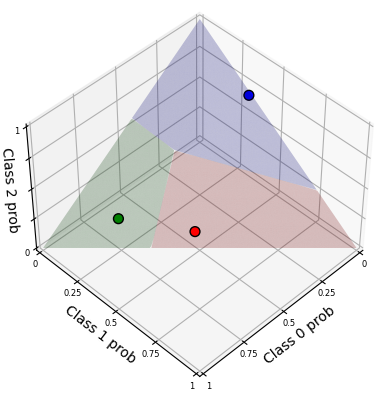

In [13]:
nn_candidates = NearestNeighbors(n_neighbors=1, p=2).fit(centroids_candidates)

ax = clean_simplex_ax(plot_3d_regions_over_simplex(nn_candidates))
ax.scatter(
    xs=centroids_candidates[:, 0],
    ys=centroids_candidates[:, 1],
    zs=centroids_candidates[:, 2],
    c=["r", "b", "g"], s=50, edgecolor="k", alpha=1
)
plt.show()

The strategy that will follow is motivated by these new regions we can build.

As these three centroids (or generically n points) of dimension three (or `n`) define how we will break the simplex into three (or `n`) different regions, we will do a [random search](https://en.wikipedia.org/wiki/Random_search) to find the position of these centroids in order to maximize a metric of interest. This technique is entirely analogous to the binary case strategy, with the difference that defining a grid, in this case, is much more difficult.

___

## Some reasonable restrictions on sampling centroid candidates

Random sampling will not always return to us the centroid points we define as valid. For example, the previous sampling is such that the corner `(1, 0, 0)` would now be classified as class 2 since it is in the region of influence of the green dot.

This problem is easy to solve just by permuting the position of the centroids so that the corners are always associated with the correct index centroid, i.e., the index of the centroid closest to `(1, 0, 0)` needs to be `0` and so on.

Also, depending on the sampling over the simplex, a centroid may be the point closest to two different corners. This case is too pathological, and it seems like a waste of time to calculate the metrics for this type of `.predict`, so we redo it when such a sample happens.

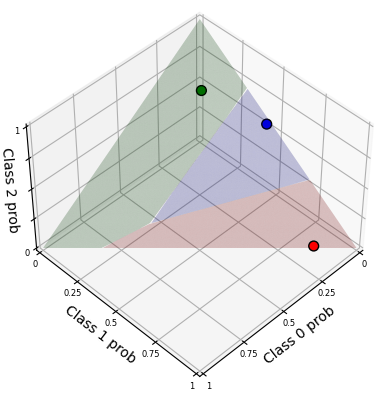

In [14]:
centroids_candidates = sample_uniform_random_vectors_over_simplex(n=3, d=3, random_state=11)

nn_candidates = NearestNeighbors(n_neighbors=1, p=2).fit(centroids_candidates)

ax = clean_simplex_ax(plot_3d_regions_over_simplex(nn_candidates))
ax.scatter(
    xs=centroids_candidates[:, 0],
    ys=centroids_candidates[:, 1],
    zs=centroids_candidates[:, 2],
    c=["r", "b", "g"], s=50, edgecolor="k", alpha=1
)
plt.show()

This reordering and resampling logic in pathological cases is implemented in the `sample_valid_random_vectors_over_simplex` function.

In [15]:
def sample_valid_random_vectors_over_simplex(n, random_state=None):
    """Sample n unique points in the n-simplex with respect to their nearest
    neighbors.

    Parameters
    ----------
    n : int
        The number of unique points to sample and also the dimension of the
        simplex.

    random_state : int or None, default=None
        Controls the random number generator used for sampling.
        Pass an int for reproducible results across multiple function calls.

    Returns
    -------
    sampled_points : array-like of shape (n, n)
        The n uniformly random vectors in the n-simplex respecting the
        restriction that each end of the simplex needs to be associated
        with only one of these points.

    Examples
    --------
    >>> unique_points = sample_unique_points(3)
    """
    def _sample_and_check(n, random_gen):
        sample = sample_uniform_random_vectors_over_simplex(
            n=n, d=n, random_state=random_gen
        )
        edges = np.identity(n)
        nn_sample = NearestNeighbors(n_neighbors=1, p=2).fit(sample)
        _, ind_edges = nn_sample.kneighbors(edges)

        if len(np.unique(ind_edges[:, 0])) == n:
            # This only happens when each simplex edge is associated with only
            # one "centroid candidate".
            return sample[ind_edges[:, 0]], True
        else:
            return None, False

    sampled_points, success = _sample_and_check(n, random_state)

    while not success:
        random_state = (
            np.random.RandomState(random_state)
            .randint(0, 2**32 - 1, dtype=np.int64)
        )
        sampled_points, success = _sample_and_check(n, random_state)

    return sampled_points

With this guarantee, we always have well-defined regions in the sense that each centroid includes one, and only one, of the corners.

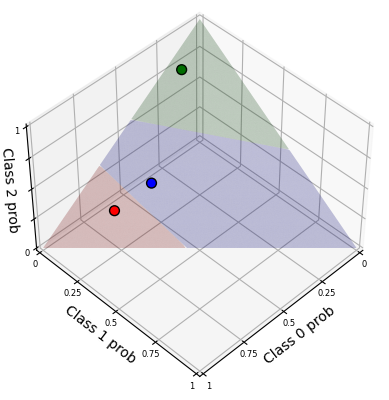

In [16]:
centroids_candidates = sample_valid_random_vectors_over_simplex(n=3, random_state=11)

nn_candidates = NearestNeighbors(n_neighbors=1, p=2).fit(centroids_candidates)

ax = clean_simplex_ax(plot_3d_regions_over_simplex(nn_candidates))
ax.scatter(
    xs=centroids_candidates[:, 0],
    ys=centroids_candidates[:, 1],
    zs=centroids_candidates[:, 2],
    c=["r", "b", "g"], s=50, edgecolor="k", alpha=1
)
plt.show()

___

## Random Search

With the previous function returning centroid candidates that respect the basic constraints discussed, we can do a brute force strategy to find a possibly better break than the [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) break. In pseudo-code, the idea of the algorithm is:

```plaintext
1. Sample a valid set of points (centroid candidates) on the simplex (meaning,
there is a bijection between each corner of the simplex and its nearest
centroid).
2. Translate probabilities into hard predictions by associating each
probability with the centroid closest to it.
3. Calculate your threshold-dependent metric of interest with the hard
predictions computed in step 2.
4. Repeat steps 1, 2, and 3 the desired number of times and store the centroids
that yield the best result in the metric of interest.
```

As the search is random, we can parallelize it straightforwardly with [`joblib.Parallel`](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html), obtaining the `optmize_threshold_multiclass_metric` function.

In [17]:
from joblib import Parallel, delayed

def optmize_threshold_multiclass_metric(
    y_proba, y_true, metric, n_iterations=100_000, n_jobs=-1
):
    """Optimize the threshold-dependent multiclass metric by sampling valid
    random vectors over the simplex and computing the metric for each set
    of centroids.
    
    Parameters
    ----------
    y_proba : array-like of shape (n_samples, n_classes)
        Probability estimates for each sample and class.
        
    y_true : array-like of shape (n_samples,)
        True class labels for each sample.
        
    metric : callable
        A callable function that takes two arguments (y_true, y_pred) and
        computes the threshold-dependent metric of interest.
        
    n_iterations : int, optional, default=100_000
        The number of iterations to perform when searching for the best set
        of centroids.
        
    n_jobs : int, optional, default=-1
        The number of CPU cores to use for parallel execution. -1 means using
        all processors.
        
    Returns
    -------
    max_metric_search : float
        The maximum value of the metric found during the search.
        
    best_centroids : array-like of shape (n_classes, n_classes)
        The set of centroids that yielded the maximum metric value.
    """
    dimension = y_proba.shape[1]

    def _compute_metric(rs, y_proba, y_true, metric):
        centroids = sample_valid_random_vectors_over_simplex(
            dimension, random_state=rs
        )
        nn_centroids = NearestNeighbors(n_neighbors=1, p=2).fit(centroids)
        _, new_preds = nn_centroids.kneighbors(y_proba)
        return metric(y_true, new_preds[:, 0])

    metric_list = Parallel(n_jobs=n_jobs)(
        delayed(_compute_metric)(rs, y_proba, y_true, metric)
        for rs in tqdm(range(n_iterations))
    )

    best_random_state = np.argmax(metric_list)
    max_metric_search = np.max(metric_list)
    best_centroids = sample_valid_random_vectors_over_simplex(
        dimension, random_state=best_random_state
    )

    return max_metric_search, best_centroids


___

## Applying the strategy

For example, for the data we are exemplifying throughout this post, we can look for better breaks than the natural break of np.argmax based on the optimization of [sklearn.metrics.matthews_corrcoef](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), for example

Por exemplo, para os dados que estamos exemplificando ao longo desse post, podemos procurar quebras melhores que a quebra natural do np.argmax baseado na otimização do , por exemplo.

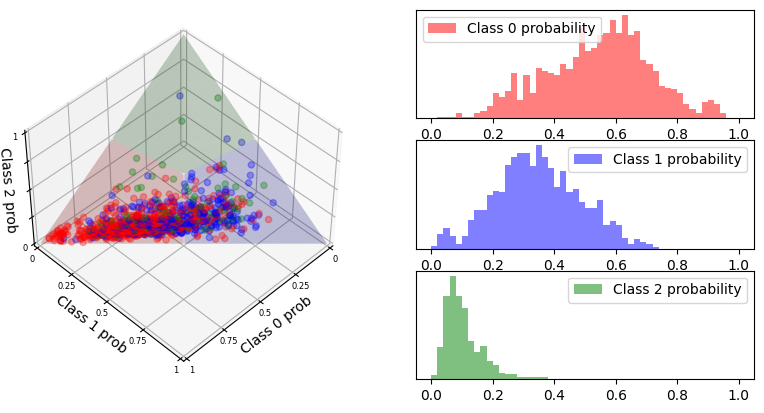

In [18]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(figsize=plt.figaspect(0.5))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

ax = (
    fig.add_subplot(gs[:, 0], projection="3d"),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, 1])
)

clean_simplex_ax(plot_3d_regions_over_simplex(nn, ax[0]))
color_list_nn = [
    color_dic[x] for x in np.array(y_train_threshold)[plot_sample]
]
ax[0].scatter(
    xs=probs[plot_sample, 0],
    ys=probs[plot_sample, 1],
    zs=probs[plot_sample, 2],
    c=color_list_nn, alpha=0.3
)

bins = np.linspace(0, 1, 51)
for class_, color in enumerate(["r", "b", "g"]):
    ax[class_ + 1].hist(
        probs[plot_sample, class_], bins=bins, alpha=0.5,
        color=color, label=f"Class {class_} probability"
    )
    ax[class_ + 1].set_yticks([])
    ax[class_ + 1].legend()

plt.show()

Applying our strategy, we have:

In [19]:
from functools import partial
from sklearn.metrics import matthews_corrcoef#, fbeta_score

metric = matthews_corrcoef
# metric = partial(fbeta_score, beta=4, average="micro")
# metric.__name__ = fbeta_score.__name__

max_metric, best_centroids = optmize_threshold_multiclass_metric(
    probs, y_train_threshold, metric, n_iterations=100_000, n_jobs=-1
)

100%|██████████| 100000/100000 [12:49<00:00, 129.91it/s]


And we were able to compare both the division of the simplex and the metric obtained with this new breakdown:

**colocar no plot abaixo o simplex do argmax usual pra ficar mais claro comparar**

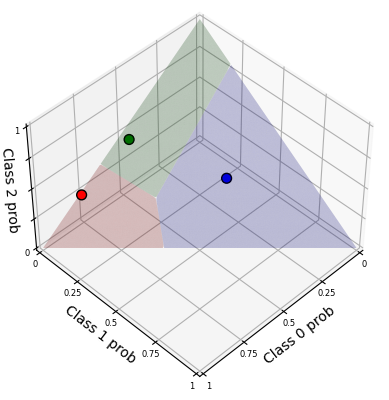

In [20]:
nn_best_centroids = NearestNeighbors(n_neighbors=1, p=2).fit(best_centroids)

ax = clean_simplex_ax(plot_3d_regions_over_simplex(nn_best_centroids))
ax.scatter(
    xs=best_centroids[:, 0],
    ys=best_centroids[:, 1],
    zs=best_centroids[:, 2],
    c=["r", "b", "g"], s=50, edgecolor="k", alpha=1
)
plt.show()

In [21]:
_, new_preds = nn_best_centroids.kneighbors(model.predict_proba(X_test))
old_preds = model.predict(X_test)

print(f"{metric.__name__} of usual predict: {metric(y_test, old_preds)}")
print(f"{metric.__name__} of optimized predict: {metric(y_test, new_preds[:, 0])}")

matthews_corrcoef of usual predict: 0.2184890999345264
matthews_corrcoef of optimized predict: 0.23797766558067351


___

## Final considerations

The main contribution of the technique developed here is how it parameterizes the simplex region search space. Unlike the binary classification in which varying the threshold is super immediate, the parameterization of the simplex break (mainly for a number of classes greater than three) is highly complex and non-intuitive.

The approach described here generalizes the observation that a neighbor search with simplex corners is equivalent to the usual `.predict`, giving us a way to look for new simplex breaks by fiddling with the positions of the points we are going to use for the neighbor search. Consequently, our parameterization is given precisely by the position of these centroids in the simplex.

___

## Some ideas for the future and care with the use of this technique

- Here we explore the mainly Euclidean distance (Minkowski with p=2) on top of the simplex. With the centroids at the simplex corners, it matches exactly how `.predict` with [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) works. However, we are exploring variations of this, so we can stick to something other than this metric. An easy variation of the proposed idea would change the p-value to see its influence.


- It is possible to change the constraints imposed on candidate centroids, which sounded reasonable initially but might not be the best.


- The idea here introduced the idea by doing a random search, which can be easily parallelized. Parallelization is very useful since our search space is relatively large due to its high dimension: we search for `n**2` parameters where `n` is the number of classes (`n` centroids with `n` components determining their position in the simplex). However, perhaps a final layer of Bayesian optimization can lead us to slightly better solutions, with a more efficient search at the brute force end.


- As noted earlier, the search space is reasonably large in a high dimension. Also, the random sample sampled from the simplex may be in regions little explored by the `.predict_proba`, which may be concentrated in some regions of the simplex. One idea for not sampling in underexplored regions might be to sample directly at the `.predict_proba`.


Using this strategy requires breaking the set into three parts: model training, threshold training, and evaluation. Unlike binary classification, in a multiclass scenario, there are `n**2` parameters to define the simplex break, as commented earlier, in contrast to just one previously, which was what we called the threshold. Especially in cases of absolute imbalance, when the training set is small, this can lead to overfitting in the calibration set. In a scenario with little data, there may be best to implement some surrogate loss that transforms the non-differentiable cost function into something more manageable (such as [this one for F1](https://arxiv.org/abs/2108.10566)) and effectively use your entire training set to train the model.


It is worth plotting (if the dataset contains three classes) the probabilities of your simplex threshold calibration set or making histograms of the probabilities of each class, as we did in our applied example, to assess whether or not it makes sense to optimize. If the model is very confident and the probabilities are very close to the edges, it will likely be more challenging to solve these cases. Intuitively, the biggest gain is when there are enough examples inside the simplex for the class switch to be relevant.

___

This text was constructed from fruitful conversations with [Alessandro](https://www.linkedin.com/in/atmg92/) and [Pablo](https://www.linkedin.com/in/pibieta/).